In [9]:
# General libraries
from os import path, listdir
from sys import path as sysPath

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For data preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For data analysis
from sklearn.metrics import confusion_matrix, accuracy_score

# For loading in Matt's python libraries for SPAM related content
sysPath.append( path.abspath( "../Support_Code/" ) )
import general_module as gm
import info_module as im
gm.test()
im.test()


GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew Ogden's information module for SPAM


In [8]:
tInfo = im.target_info_class( targetDir = '../../spam_data_pl3/587722984435351614/', printAll = False, newInfo=False)
print(tInfo.status)

True


In [ ]:
# Read data and split into training/testing
wndDir = tInfo.targetDir + 'wndcharm/'
rawLoc = wndDir + 'rawFeats.csv'
rawFeats = pd.read_csv(rawLoc)
print(rawFeats)

In [133]:
# Filter out any rows with invalid values
validFeats = rawFeats[~rawFeats.isin([np.nan, np.inf, -np.inf]).any(1)]

print("Before: ", rawFeats.shape[0])
print("After : ", validFeats.shape[0])

# Plot some basic information about the features
X = validFeats.iloc[:,2:-1].values 
y = validFeats.iloc[:,1].values  # Continue value
nFeats = X.shape[1]
print('X:', X.shape)
print('y:', y.shape)

# Preprocess data and save scalar for later use
from pickle import dump

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

scaleLoc = wndDir + 'scaler.pkl'
dump(sc, open(scaleLoc, 'wb'))


Before:  9987
After :  9972
X: (9972, 2918)
y: (9972,)


5102
(1, 5102, 2918) (5102,)
(1, 4870, 2918) (4870,)



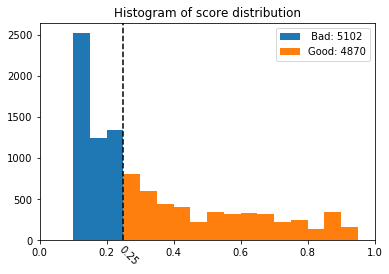

In [134]:
badId = np.where( yc < 0.25 )
goodId = np.where( yc >= 0.25 )
print(len(veryBad[0]))
badX = X[badId,:]
badY = y[badId]
goodX = X[goodId,:]
goodY = y[goodId]
print(badX.shape, badY.shape)
print(goodX.shape, goodY.shape)
print("")

plt.hist( badY, bins=20, range=(0,1), label=' Bad: %d'%badY.shape[0] )
plt.hist(goodY, bins=20, range=(0,1), label='Good: %d'%goodY.shape[0] )
plt.axvline(0.25, c='k', ls='--', )
plt.text(0.23,-300,'0.25', rotation=-45)
plt.title("Histogram of score distribution")
plt.legend()
plt.xlim([0,1])
plt.show()

In [137]:
# Create discrete labels for those above and below 0.25
y1 = np.zeros(y.shape[0])
y1[y>0.25] = 1
y1 = y1.astype(int)

# sample y values for confirmation
for i in range(0,9900,1000):
    print('%.2f -> %d ' % ( y[i], y1[i] ) )
          

0.95 -> 1 
0.71 -> 1 
0.56 -> 1 
0.40 -> 1 
0.31 -> 1 
0.24 -> 0 
0.20 -> 0 
0.17 -> 0 
0.15 -> 0 
0.14 -> 0 


In [ ]:
# For retrieving basic statistics on predicted vs actual
def get_stats( y, y_pred ):
    # print results
    cm = confusion_matrix( y, y_pred )
    acc =  accuracy_score( y, y_pred )
    
    return cm, acc

class dec_tree_class:
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn import tree
    
    # Variables 
    k_fold = 10
    name = 'decision_tree'
    classifier = None
    depth = 4   
    
    def __init__( self, X_train, y_train, criterion = 'entropy' ):

        # Training data
        self.criterion = criterion
        self.classifier = self.DecisionTreeClassifier(max_depth=2, criterion = self.criterion, random_state = 0 )
        self.classifier = self.classifier.fit(X_train, y_train)
    
    def predict( self, X_test ):        
        return self.classifier.predict( X_test )
        
    def plotTree( self, X_train, y_train, depth = 2 ):

        # Training data
        self.classifier = self.DecisionTreeClassifier(max_depth=self.depth, criterion = self.criterion, random_state = 0 )
        self.classifier = self.classifier.fit(X_train, y_train)
        self.tree.plot_tree( self.classifier )
    
    def cv_accuracy( self, X, y, k_fold = 5, depth=3 ):
        
        from sklearn.model_selection import KFold
        kf = KFold( n_splits= k_fold )
        
        scores = np.zeros(k_fold)
        
        for i, indexes in enumerate( kf.split( X ) ):
            
            print("Cross Validate: %d"%i,end='\r')
            
            train_i, test_i = indexes
            
            tx_train, tx_test = X[train_i], X[test_i]
            ty_train, ty_test = y[train_i], y[test_i]   
            
            temp_class = self.DecisionTreeClassifier( max_depth=depth, criterion = self.criterion, random_state = 0 )
            temp_class = temp_class.fit( tx_train, ty_train )            
            ty_pred = temp_class.predict( tx_test )
            
            t_cm, t_acc = get_stats( ty_test, ty_pred )
            
            scores[i] = t_acc
            
            
        return np.mean( scores )
        
dt_classifier = dec_tree_class( X, y1, )  
print(dt_classifier.name) 
print(dt_classifier.cv_accuracy(X,y1))
#dt_classifier.plotTree(X,y1)

scores = []

for i in range(1,10):
    scores.append( dt_classifier.cv_accuracy(X,y1, depth=i) )

Text(0.5, 0, 'Tree Depth')

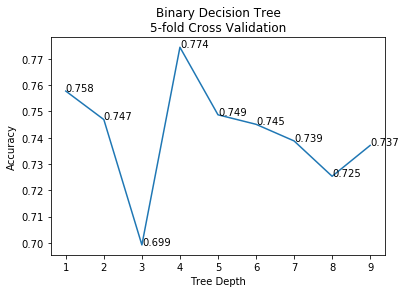

In [159]:
plt.plot(range(1,10),scores)
for i,s in enumerate(scores):    
    plt.text( i+1, s, '%.3f'%s, rotation=0)

plt.title("Binary Decision Tree\n5-fold Cross Validation")
plt.ylabel("Accuracy")
plt.xlabel("Tree Depth")

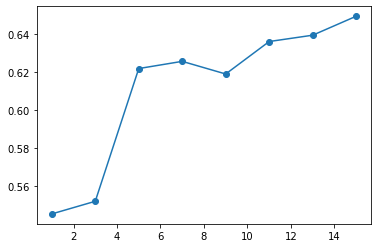

In [5]:
class k_neighbor_class:
    
    from sklearn.neighbors import KNeighborsClassifier
    
    # Variables 
    name = "K_Nearest_Neighbor"
    
    
    def __init__( self, X_train, y_train, n_neighbors = 15 ):
        
        self.n_neighbors = n_neighbors
        self.classifier = self.KNeighborsClassifier(n_neighbors = n_neighbors, metric = 'minkowski', p = 2, )
        self.classifier = self.classifier.fit(X_train, y_train)
    
    def predict( self, X_test ):        
        return self.classifier.predict( X_test )
    
    def cv_accuracy( self, X_train, y_train, k_fold = 10 ):
        
        from sklearn.model_selection import KFold
        kf = KFold( n_splits= k_fold )
        
        scores = np.zeros(k_fold)
        
        for i, indexes in enumerate( kf.split( X_train ) ):
            
            train_i, test_i = indexes
            
            tx_train, tx_test = X_train[train_i], X_train[test_i]
            ty_train, ty_test = y_train[train_i], y_train[test_i]   
            
            temp_class = self.KNeighborsClassifier( n_neighbors = self.n_neighbors, metric = 'minkowski', p = 2, )
            temp_class = temp_class.fit( tx_train, ty_train )            
            ty_pred = temp_class.predict( tx_test )
            
            t_cm, t_acc = get_stats( ty_test, ty_pred )
            
            scores[i] = t_acc
            
        return np.mean( scores )

# prep plot
nmin = 1
nmax = 15
nstep = int( (nmax-nmin) / 2 + 1)

x_plot = np.linspace( nmin, nmax, nstep)
y_plot = np.zeros( len(x_plot) )

# fill plot
for i,x in enumerate(x_plot):    
    kn_classifier = k_neighbor_class( X, y, n_neighbors = int(x) )
    fold_scores = kn_classifier.cv_accuracy( X, y )
    y_plot[i] = fold_scores
    
plt.plot(x_plot,y_plot,'o-')
plt.show()

In [14]:
class naive_bayes_class:
    
    from sklearn.naive_bayes import GaussianNB
    
    # Variables 
    name = "Gaussian Naive Bayes"
    
    def __init__( self, X_train, y_train, n_neighbors = 15 ):
        
        self.classifier = self.GaussianNB()
        self.classifier = self.classifier.fit(X_train, y_train)
    
    def predict( self, X_test ):        
        return self.classifier.predict( X_test )
    
    def cv_accuracy( self, X_train, y_train, k_fold = 10 ):
        
        from sklearn.model_selection import KFold
        kf = KFold( n_splits= k_fold )
        
        scores = np.zeros(k_fold)
        
        # Loop through k-fold divisions and get score
        for i, indexes in enumerate( kf.split( X_train ) ):
            
            train_i, test_i = indexes
            
            tx_train, tx_test = X_train[train_i], X_train[test_i]
            ty_train, ty_test = y_train[train_i], y_train[test_i]   
            
            temp_class = self.GaussianNB()
            temp_class = temp_class.fit( tx_train, ty_train )            
            ty_pred = temp_class.predict( tx_test )
            
            t_cm, t_acc = get_stats( ty_test, ty_pred )
            
            scores[i] = t_acc
            
        return np.mean( scores )

nb_classifier = naive_bayes_class( X, y, )
fold_scores = nb_classifier.cv_accuracy( X, y )
print(fold_scores)

0.8


In [ ]:
class nn_class:
    
    import tensorflow as tf
    
    # Variables 
    name = "artificial neural network"
    
    def __init__( self, X_train, y_train, depth = 3, width, =  ):
        
        self.n_neighbors = n_neighbors
        self.classifier = self.KNeighborsClassifier(n_neighbors = n_neighbors, metric = 'minkowski', p = 2, )
        self.classifier = self.classifier.fit(X_train, y_train)
    
    def predict( self, X_test ):        
        return self.classifier.predict( X_test )
    
    def cv_accuracy( self, X_train, y_train, k_fold = 10 ):
        
        from sklearn.model_selection import KFold
        kf = KFold( n_splits= k_fold )
        
        scores = np.zeros(k_fold)
        
        for i, indexes in enumerate( kf.split( X_train ) ):
            
            train_i, test_i = indexes
            
            tx_train, tx_test = X_train[train_i], X_train[test_i]
            ty_train, ty_test = y_train[train_i], y_train[test_i]   
            
            temp_class = self.KNeighborsClassifier( n_neighbors = self.n_neighbors, metric = 'minkowski', p = 2, )
            temp_class = temp_class.fit( tx_train, ty_train )            
            ty_pred = temp_class.predict( tx_test )
            
            t_cm, t_acc = get_stats( ty_test, ty_pred )
            
            scores[i] = t_acc
            
        return np.mean( scores )

# prep plot
nmin = 1
nmax = 15
nstep = int( (nmax-nmin) / 2 + 1)

x_plot = np.linspace( nmin, nmax, nstep)
y_plot = np.zeros( len(x_plot) )

# fill plot
for i,x in enumerate(x_plot):    
    kn_classifier = k_neighbor_class( X, y, n_neighbors = int(x) )
    fold_scores = kn_classifier.cv_accuracy( X, y )
    y_plot[i] = fold_scores
    
plt.plot(x_plot,y_plot,'o-')
plt.show()

In [16]:
methodList = [ log_reg_class, k_neighbor_class, dec_tree_class, naive_bayes_class ]

for m_class in methodList:
    m = m_class( X, y )
    acc = m.cv_accuracy( X, y )
    
    print( '%s: %f' % (m.name, acc) )
    #print( '\n' )

Logistic_Regression: 0.806667
K_Nearest_Neighbor: 0.649540
decision_tree: 0.786092
Gaussian Naive Bayes: 0.800000


In [9]:
# help
